In [2]:
import numpy as np 
import pandas as pd 
import os 
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix #lets visualise the model predictions 
import seaborn as sns
from sklearn.metrics import accuracy_score
import joblib

In [3]:
train = Path('./kaggle/train/') #getting the path of the train dataset
train_filepaths = list(train.glob(r'**/*.jpg')) #glob (short for global) is used to return all file paths that match a specific pattern

valid = Path('./kaggle/validation/')#for valid dataset
valid_filepaths = list(valid.glob(r'**/*.jpg'))

test = Path('./kaggle/test/')#for test dataset
test_filepaths = list(test.glob(r'**/*.jpg'))

user_input = Path('./kaggle/user_input/')#for user input dataset
user_input_filepaths = list(user_input.glob(r'**/*.jpg'))

In [4]:
def process_img(filepath): # passing the filepaths of datasets
    
    labels = [str(filepath[i]).split("\\")[-2] #here we are trying to extract the labels for the fruits and veggies by using .split method and
              for i in range(len(filepath))] #since names are secound last word we used [-2] to get that particular name
    # print(labels)
    filepath = pd.Series(filepath, name='FilePath').astype(str)
    labels = pd.Series(labels, name='Label') 
    
    df = pd.concat([filepath, labels], axis=1) 
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [5]:
train_df = process_img(train_filepaths) 
valid_df = process_img(valid_filepaths)
test_df = process_img(test_filepaths)
user_input_df = process_img(user_input_filepaths)

In [29]:
train_df.head()

,FilePath,Label
0,kaggle\train\lettuce\Image_1.jpg,lettuce
1,kaggle\train\cabbage\Image_73.jpg,cabbage
2,kaggle\train\cabbage\Image_95.jpg,cabbage
3,kaggle\train\spinach\Image_41.jpg,spinach
4,kaggle\train\apple\Image_49.jpg,apple


In [30]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(set(train_df.Label))}\n')
print(f'Labels: {set(train_df.Label)}')

-- Training set --

Number of pictures: 2855

Number of different labels: 36

Labels: {'raddish', 'sweetcorn', 'pomegranate', 'lettuce', 'ginger', 'peas', 'kiwi', 'bell pepper', 'mango', 'banana', 'pineapple', 'soy beans', 'eggplant', 'corn', 'onion', 'tomato', 'grapes', 'cauliflower', 'apple', 'orange', 'garlic', 'cabbage', 'carrot', 'chilli pepper', 'beetroot', 'potato', 'pear', 'turnip', 'capsicum', 'paprika', 'spinach', 'jalepeno', 'watermelon', 'sweetpotato', 'cucumber', 'lemon'}


In [31]:
print(f'Labels: {set(test_df.Label)}')

Labels: {'raddish', 'sweetcorn', 'pomegranate', 'lettuce', 'peas', 'ginger', 'kiwi', 'bell pepper', 'mango', 'banana', 'soy beans', 'pineapple', 'eggplant', 'corn', 'tomato', 'onion', 'grapes', 'cauliflower', 'apple', 'orange', 'garlic', 'cabbage', 'carrot', 'chilli pepper', 'beetroot', 'potato', 'pear', 'turnip', 'capsicum', 'paprika', 'spinach', 'jalepeno', 'watermelon', 'sweetpotato', 'cucumber', 'lemon'}


In [ ]:
unique_labels = train_df.copy().drop_duplicates(subset=['Label']).reset_index() #we want to see unique images so we are dropping duplicates and since we dont
                                                                                    #want to mess up the original df we are coping it using .copy()

fig, axes = plt.subplots(6,6, figsize=(10,10),subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(unique_labels.FilePath[i]))
    ax.set_title(unique_labels.Label[i], fontsize=12)
    
plt.tight_layout()
plt.show()

In [33]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = data_gen.flow_from_dataframe(
    dataframe = train_df,
    x_col='FilePath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

valid_images = data_gen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='FilePath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = data_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='FilePath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

# random images from internet
random_images = data_gen.flow_from_dataframe(
    dataframe=user_input_df,
    x_col='FilePath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
)

Found 2855 validated image filenames belonging to 36 classes.
Found 340 validated image filenames belonging to 36 classes.
Found 340 validated image filenames belonging to 36 classes.
Found 1 validated image filenames belonging to 1 classes.


In [8]:
base_model =  tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='avg',
) #this is our base model 

base_model.trainable = False # we dont want to train the intial weights so we use .trainable = False 

In [ ]:
base_model.summary()

In [9]:
inputs = base_model.input # this is our input layer which is the base_model's input

x = tf.keras.layers.Dense(128, activation='relu')(base_model.output) #here we passed this base_model.output coz on top of our x layer we want the output(bottom) layer of base_model
x = tf.keras.layers.Dense(256, activation='relu')(x) 

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)# here we have 36 diff classes so we take 36 as output

model = tf.keras.Model(inputs=inputs, outputs=outputs) # we are passing in our inputs and outputs to our model now

model.compile(                                           #lets just compile everthing together 
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
history = model.fit(                    #fit the model 
    train_images,
    validation_data=valid_images,
    batch_size = 32,
    epochs=5,
    callbacks=[                   #we are using callbacks for early stopping in case our model doesn't show any improvement after 2 epochs monitoring the monitering the validation loss
        tf.keras.callbacks.EarlyStopping(  
            monitor='val_loss',
            patience=2,
            restore_best_weights=True #it literally means wat u think (simpleeeeee)
        )
    ]
)

Epoch 1/5
90/90 [==============================] - 165s 2s/step - loss: 1.6926 - accuracy: 0.5524 - val_loss: 0.4590 - val_accuracy: 0.8529
Epoch 2/5
90/90 [==============================] - 149s 2s/step - loss: 0.5564 - accuracy: 0.8235 - val_loss: 0.2985 - val_accuracy: 0.9118
Epoch 3/5
90/90 [==============================] - 147s 2s/step - loss: 0.3411 - accuracy: 0.8841 - val_loss: 0.2753 - val_accuracy: 0.9029
Epoch 4/5
90/90 [==============================] - 148s 2s/step - loss: 0.2233 - accuracy: 0.9296 - val_loss: 0.1740 - val_accuracy: 0.9559
Epoch 5/5
90/90 [==============================] - 145s 2s/step - loss: 0.1429 - accuracy: 0.9552 - val_loss: 0.1657 - val_accuracy: 0.9441


In [40]:
# save the model to disk
model.save('./model.h5')

In [42]:
# load the model from disk
loaded_model = tf.keras.models.load_model('./model.h5')

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()  # we are plotting the train and validation accuracy to check on if its overfitting 
plt.title('Accuracy')
plt.show()

In [ ]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Loss')
plt.show()

In [43]:
pred = loaded_model.predict(test_images) #its predicting time , our model will try to predict the prob of the particular class 
pred = np.argmax(pred, axis=1) # we are seeing the highest prob value and taking the index of it  

11/11 [==============================] - 47s 4s/step


In [ ]:
pred 

In [44]:
labels = (train_images.class_indices) #this gives us the labels with indicies to map
labels

{'apple': 0,
 'banana': 1,
 'beetroot': 2,
 'bell pepper': 3,
 'cabbage': 4,
 'capsicum': 5,
 'carrot': 6,
 'cauliflower': 7,
 'chilli pepper': 8,
 'corn': 9,
 'cucumber': 10,
 'eggplant': 11,
 'garlic': 12,
 'ginger': 13,
 'grapes': 14,
 'jalepeno': 15,
 'kiwi': 16,
 'lemon': 17,
 'lettuce': 18,
 'mango': 19,
 'onion': 20,
 'orange': 21,
 'paprika': 22,
 'pear': 23,
 'peas': 24,
 'pineapple': 25,
 'pomegranate': 26,
 'potato': 27,
 'raddish': 28,
 'soy beans': 29,
 'spinach': 30,
 'sweetcorn': 31,
 'sweetpotato': 32,
 'tomato': 33,
 'turnip': 34,
 'watermelon': 35}

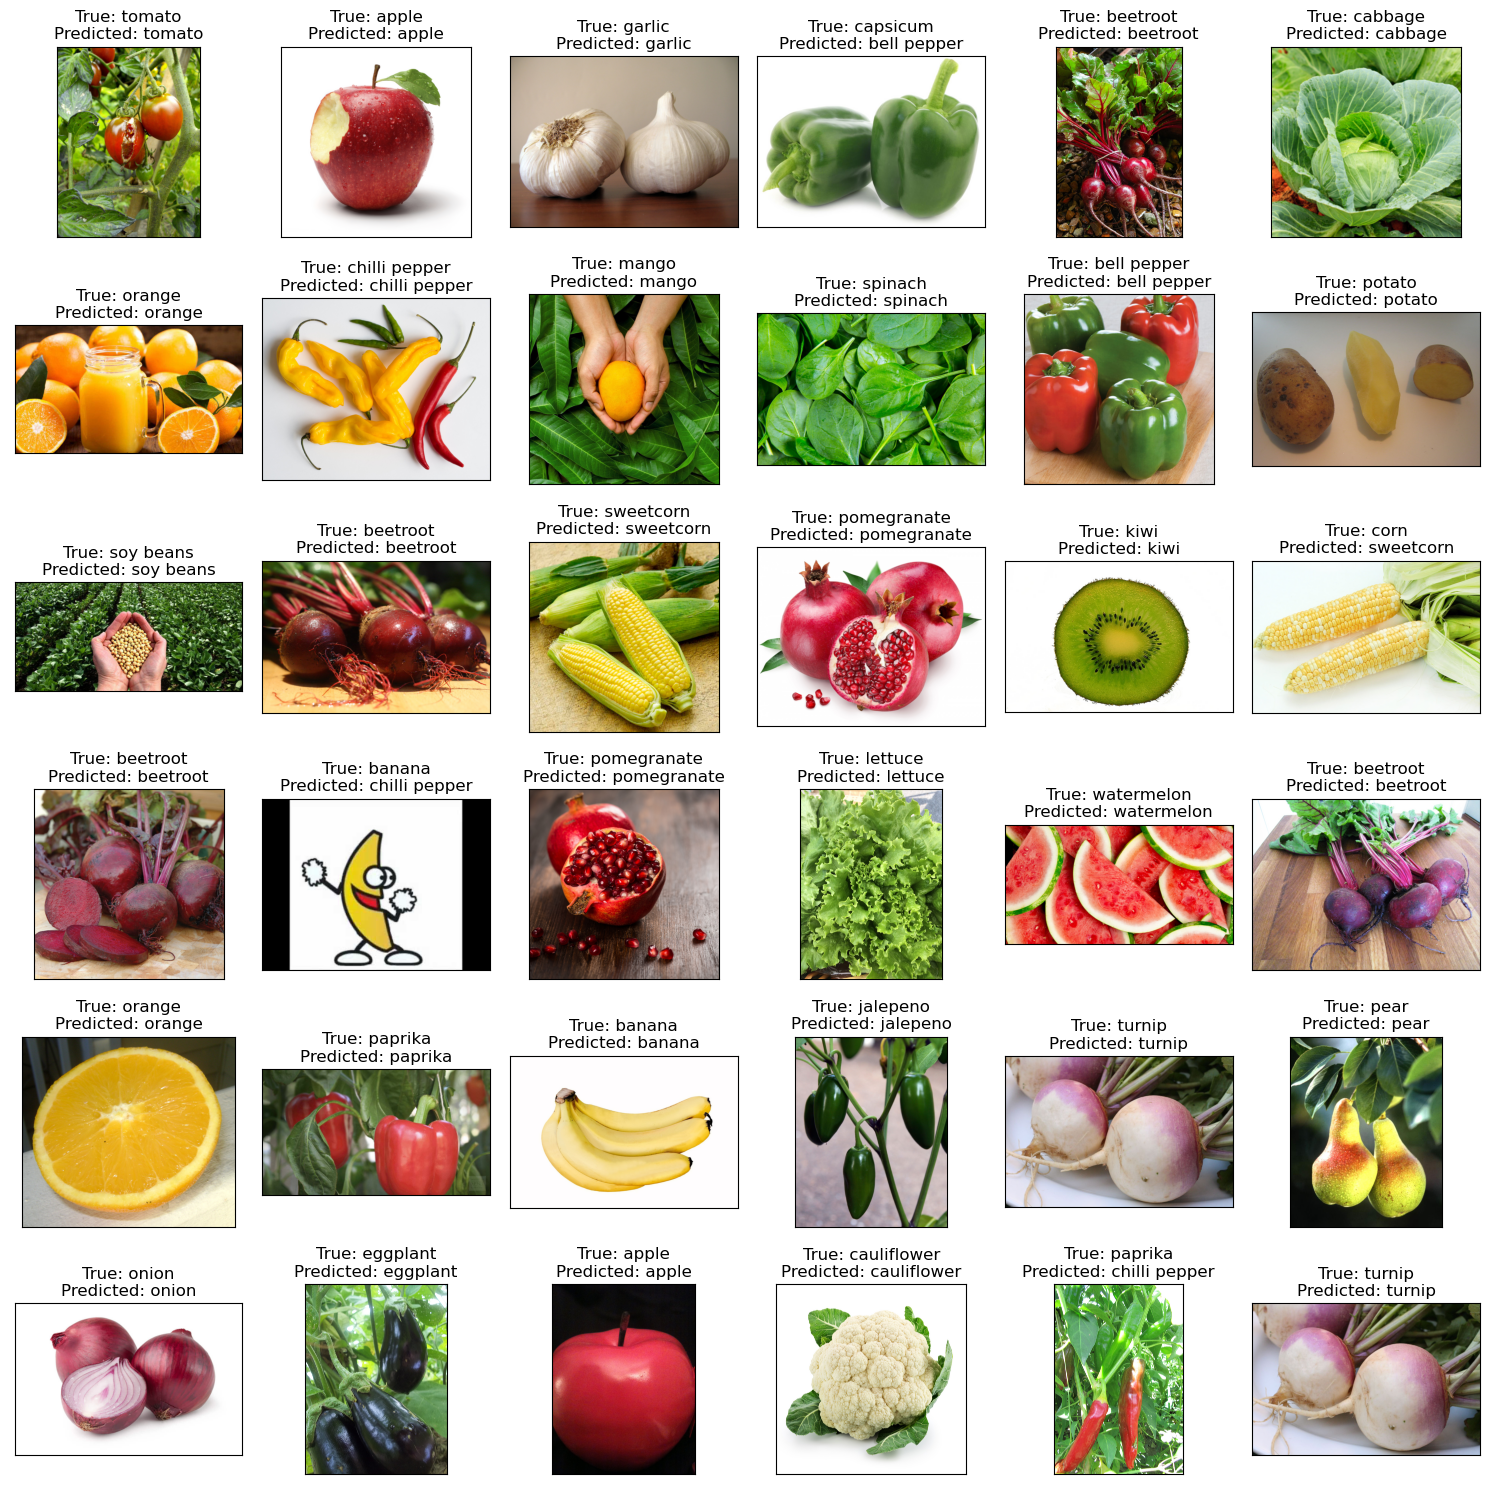

In [45]:
fig, axes = plt.subplots(6,6,figsize=(15,15), subplot_kw={'xticks': [], 'yticks': []}) #will see the actual and predicted labels with images.

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.FilePath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {list(labels.keys())[list(labels.values()).index(pred[i])]}")
plt.tight_layout()
plt.show()

In [46]:
# get the lable of the predicted food 
predicted_label = list(labels.keys())[pred[0]]
predicted_label



'tomato'